# Pulse Optimization for our Hamiltonian

Import necessary functions

In [5]:
from optimize_pulses import optimizer
from qutip import Qobj, identity, sigmax, sigmaz,sigmay
import matplotlib.pyplot as plt
import numpy as np
import copy
import numpy as np
import matplotlib.pyplot as plt
pi = np.pi
from qutip.qip.device import Processor
from qutip.operators import sigmaz
from qutip.states import basis
from random_single_clifford import random_clifford_sequence

C:\Users\thoma\Documents\Qutip_Work\random_single_clifford.py:2: DeprecationWarning: Importation from qutip.qip.gates is deprecated.Please use e.g.
 from qutip.qip.operations import cnot

  from qutip.qip.gates import rx,ry


In [54]:
# Drift Hamiltonian
H_d = sigmaz()
# The (single) control Hamiltonian
H_c = [sigmax()]
# Number of time slots
n_ts = 10
# Time allowed for the evolution
evo_time = 1

## Create random Clifford sequence pulses

In [55]:
n_gates = 10
sequence = random_clifford_sequence(n_gates)
pulses = np.zeros(n_gates*n_ts)

In [56]:
for i in range(len(sequence)):
    U_targ = sequence[i]
    time,coeffs = optimizer(H_d,H_c,U_targ,n_ts,evo_time)
    print(i*n_ts)
    pulses[i*n_ts:(i+1)*n_ts] = coeffs[:,0]

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
Control 1 Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]
Initial state / operator:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]
Target state / operator:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 6.123234e-17 -1.0000

0


INFO:qutip.control.pulseoptim:Final amplitudes output to file: ctrl_amps_final_Test_n_ts10_ptypeRND.txt
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
Control 1 Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]
Initial state / operator:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]
Target state / operator:
Quantum ob

10
20


INFO:qutip.control.pulseoptim:Final amplitudes output to file: ctrl_amps_final_Test_n_ts10_ptypeRND.txt
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
Control 1 Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]
Initial state / operator:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]
Target state / operator:
Quantum ob

30
40


INFO:qutip.control.pulseoptim:Final amplitudes output to file: ctrl_amps_final_Test_n_ts10_ptypeRND.txt
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
Control 1 Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]
Initial state / operator:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]
Target state / operator:
Quantum ob

50
60


INFO:qutip.control.pulseoptim:Final amplitudes output to file: ctrl_amps_final_Test_n_ts10_ptypeRND.txt
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
Control 1 Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]
Initial state / operator:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]
Target state / operator:
Quantum ob

70
80


INFO:qutip.control.pulseoptim:Final amplitudes output to file: ctrl_amps_final_Test_n_ts10_ptypeRND.txt


90


In [60]:
time = np.arange(0,evo_time*n_gates,evo_time/n_ts)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ce00877910>)

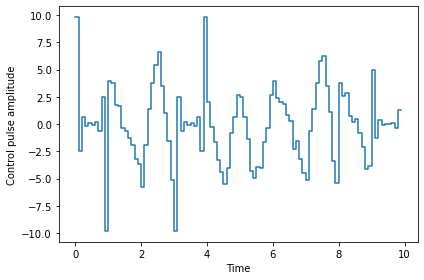

In [62]:
T2 = 5
T1 = 4

processor = Processor(N=1, spline_kind="step_func",t1=T1,t2=T2)
processor.add_control(sigmax(), 0)
processor.add_drift(sigmaz(), 0)

processor.pulses[0].tlist = time
processor.pulses[0].coeff = pulses
processor.plot_pulses()

In [63]:
zero_state = basis(2, n=0)
result = processor.run_state(zero_state)

In [64]:
result

Result object with mesolve data.
--------------------------------
states = True
num_collapse = 0